# Import Dependencies

In [3]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall

# Import uuid lib to generate unique image names
import uuid

# connect to webcam
from tkinter import image_names


In [4]:
import keras
print(keras.__version__)
print(tf.__version__)

2.10.0
2.10.1


In [5]:
# used to generate unique image file names
uuid??

Type:        module
String form: <module 'uuid' from 'c:\\Users\\Admin\\anaconda3\\envs\\nick_facial_recog\\lib\\uuid.py'>
File:        c:\users\admin\anaconda3\envs\nick_facial_recog\lib\uuid.py
Source:     
r"""UUID objects (universally unique identifiers) according to RFC 4122.

This module provides immutable UUID objects (class UUID) and the functions
uuid1(), uuid3(), uuid4(), uuid5() for generating version 1, 3, 4, and 5
UUIDs as specified in RFC 4122.

If all you want is a unique ID, you should probably call uuid1() or uuid4().
Note that uuid1() may compromise privacy since it creates a UUID containing
the computer's network address.  uuid4() creates a random UUID.

Typical usage:

    >>> import uuid

    # make a UUID based on the host ID and current time
    >>> uuid.uuid1()    # doctest: +SKIP
    UUID('a8098c1a-f86e-11da-bd1a-00112444be1e')

    # make a UUID using an MD5 hash of a namespace UUID and a name
    >>> uuid.uuid3(uuid.NAMESPACE_DNS, 'python.org')
    UUID('6fa4

# Set GPU

In [6]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# avoid out of memory errors by setting GPU consumption growth

gpus = tf.config.experimental.list_physical_devices("GPU") # get all list of GPUs

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True) # set memory growth to true

In [8]:
# check if GPU is available
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# Create Folder

POS_PATH = os.path.join('data', 'positive')

NEG_PATH = os.path.join('data', 'negative')

ANC_PATH = os.path.join('data', 'anchor')

In [11]:
POS_PATH

'data\\positive'

In [ ]:
# make directories

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect positives and Anchors

#### 2.1) Untar labelled faces in the dataset

http://vis-www.cs.umass.edu/lfw/

In [ ]:
# uncompress Tar GZ labelled Faces in the wild dataset
!tar -xf lfw.tgz

#### Move LFW images to the respective data/negative folder

In [ ]:

# loop through every single dir inside lfw folder
for directory in os.listdir("lfw"):
    # loop through every file inside each directory in lfw folder
    for file in os.listdir(os.path.join("lfw", directory)):
        # existing path
        EX_PATH = os.path.join("lfw", directory, file)
        print("************OLD PATH************")
        #print(EX_PATH)
        # new path
        print("************NEW PATH************")
        NEW_PATH = os.path.join(NEG_PATH, file)
        #print(NEW_PATH)
        os.replace(EX_PATH, NEW_PATH)

Images in the wild dataset have resolution 250*250 so we will capture our image with the same resolution

### 2.2) Collect Positive and Anchors classes

In [ ]:
cap = cv2.VideoCapture(0)

# loop through every single frame of webcam
while cap.isOpened():
    # read the capture frame one at a time and unpack the result to get 'return' and 'frame'
    ret, frame = cap.read()
    # cut down frame to 250*250 px
    frame = frame[120:120+250, 150:200+250, :]
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord("a"):
        # create a unique file path. We are appending a unique identitfier to every image
        # we will save the img in data//anchor//img_name.jpg folder
        img_name = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(img_name, frame)
        
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord("p"):
        # create a unique file path. We are appending a unique identitfier to every image
        # we will save the img in data//positive//img_name.jpg folder
        img_name = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(img_name, frame)
    
    
    # render that image on the screen
    cv2.imshow("Image Collection", frame)
    # break out of the webcam frame
    if cv2.waitKey(1) & 0XFF == ord("q"):
        break
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

In [ ]:
frame.shape

In [ ]:
# We need to make the resolution of webcam frame to match the resolution of images in the dataset i.e. 250 * 250

frame[:250, :250, :].shape

In [ ]:
# plot it
plt.imshow(frame[:250, :250, :])

We need to capture the face from the frame

In [ ]:
# y axis = starting at 120 pixels to 120+250 pixels
# x axis = starting at 200 pixel to 200+250
# we need all 3 channels
plt.imshow(frame[120:120+250, 150:200+250, :])

# 3. Load and Preprocess Images

#### 3.1 Get Image Directories

In [12]:
# grab 700 of .jpg images from respective anchor, postive, negative directories
anchor = tf.data.Dataset.list_files(ANC_PATH + "\*.jpg").take(750)

positive = tf.data.Dataset.list_files(POS_PATH + "\*.jpg").take(750)

negative = tf.data.Dataset.list_files(NEG_PATH + "\*.jpg").take(750)

In [13]:
ANC_PATH + "\*.jpg"

'data\\anchor\\*.jpg'

In [14]:
# test the above code
dir_test = anchor.as_numpy_iterator()

In [15]:
# we get each img every time we run this cell
dir_test.next()

b'data\\anchor\\fb194188-3219-11ed-bb39-509a4cb51153.jpg'

#### 3.2 Preprocessing - Scale and Resize

In [16]:
def preprocess(file_path):
    """resize to 100*100 and scale image between 0 to 1

    Args:
        file_path (_type_): path to image

    Returns:
        img: return image after preprocessing
    """
    
    # read img from file path
    byte_img = tf.io.read_file(file_path)
    # load image using decode jpeg
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resize to 100*100*3 (similar to research paper)
    img = tf.image.resize(img, (100, 100))
    # scale img between 0 to 1
    img = img / 255.0
    return img
    

In [17]:
# test preprocess method
img = preprocess("data\\anchor\\d26b187a-3219-11ed-bc34-509a4cb51153.jpg")

In [18]:
img.numpy().min()

0.0

In [19]:
img.numpy().max()

0.92745095

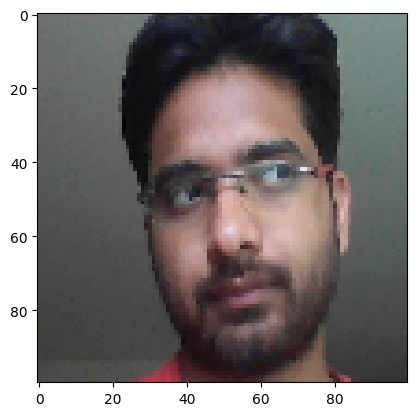

In [20]:
plt.imshow(img)

#### 3.3 Create Labelled Dataset

In [21]:
tf.ones(len(anchor))

<tf.Tensor: shape=(750,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [22]:
# negatives
tf.zeros(len(anchor))

<tf.Tensor: shape=(750,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [23]:
class_lables = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))

In [24]:
iterator_labels = class_lables.as_numpy_iterator()

In [25]:
# loop thru each label in the positives
iterator_labels.next()

0.0

In [26]:
# we can do the same as above with tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))) method
# (anchor or input image, positive image) => 1,1,1,1,1
# (anchor or input image, negative image) => 0,0,0,0,0

# create a tuple of anchor image path, positive or negative image path and class label( 0 or 1) and store in data variable
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# nagative tuple
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# concatenate both positive and negative datasets
data = positives.concatenate(negatives)

In [27]:
# 1D output in form of ((anchor or input images), (positives or negatives), (1 or 0))
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [28]:

samples = data.as_numpy_iterator()

In [29]:
example = samples.next()

In [30]:
example

(b'data\\anchor\\e2a7ae31-3219-11ed-812f-509a4cb51153.jpg',
 b'data\\positive\\7428cd51-321a-11ed-87a5-509a4cb51153.jpg',
 1.0)

### 3.4 Build Train and Test Partition

In [31]:
def preprocess_twin(input_img, validation_img, label):
    '''
    Get the actual images instead of file path
    '''
    # preprocess input image
    input_img = preprocess(input_img)
    # preprocess validation image
    validation_img = preprocess(validation_img)
    return input_img, validation_img, label

In [32]:
# * unpacks the values inside the tuple
res = preprocess_twin(*example)

In [33]:
# it's a tuple of 3 different things i.e. (anchor image, positive or negative image, class label: 1 or 0).
len(res)

3

In [34]:
# anchor sample
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.4715686 , 0.4715686 , 0.4715686 ],
        [0.4745098 , 0.4745098 , 0.4745098 ],
        [0.48137254, 0.48137254, 0.48137254],
        ...,
        [0.58431375, 0.5921569 , 0.5803922 ],
        [0.5872549 , 0.595098  , 0.5833333 ],
        [0.5892157 , 0.5892157 , 0.58137256]],

       [[0.46666667, 0.46666667, 0.46666667],
        [0.46666667, 0.46666667, 0.46666667],
        [0.46960783, 0.46960783, 0.46960783],
        ...,
        [0.58431375, 0.5921569 , 0.58235294],
        [0.57941175, 0.5872549 , 0.577451  ],
        [0.5852941 , 0.595098  , 0.5852941 ]],

       [[0.4598039 , 0.4598039 , 0.4598039 ],
        [0.46666667, 0.46666667, 0.46666667],
        [0.46568626, 0.46568626, 0.46568626],
        ...,
        [0.57941175, 0.59313726, 0.5892157 ],
        [0.56960785, 0.59117645, 0.58431375],
        [0.56666666, 0.5882353 , 0.58137256]],

       ...,

       [[0.25882354, 0.2617647 , 0.24509804],
        [0.26

In [35]:
# positive sample
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.4509804 , 0.4509804 , 0.44313726],
        [0.4509804 , 0.4509804 , 0.44313726],
        [0.4480392 , 0.4480392 , 0.44019607],
        ...,
        [0.5382353 , 0.58137256, 0.5656863 ],
        [0.53333336, 0.5803922 , 0.5647059 ],
        [0.5372549 , 0.5833333 , 0.56764704]],

       [[0.45      , 0.45      , 0.44215685],
        [0.45392156, 0.45392156, 0.44607842],
        [0.4480392 , 0.4480392 , 0.44019607],
        ...,
        [0.53137255, 0.577451  , 0.5617647 ],
        [0.52843136, 0.58431375, 0.5656863 ],
        [0.53137255, 0.5872549 , 0.5686275 ]],

       [[0.44705883, 0.44705883, 0.4392157 ],
        [0.44705883, 0.44705883, 0.4392157 ],
        [0.45196077, 0.45196077, 0.44411764],
        ...,
        [0.5539216 , 0.5745098 , 0.5686275 ],
        [0.55784315, 0.57843137, 0.57254905],
        [0.5411765 , 0.57843137, 0.5656863 ]],

       ...,

       [[0.24607843, 0.25196078, 0.24117647],
        [0.25

In [36]:
# class label
res[2]

1.0

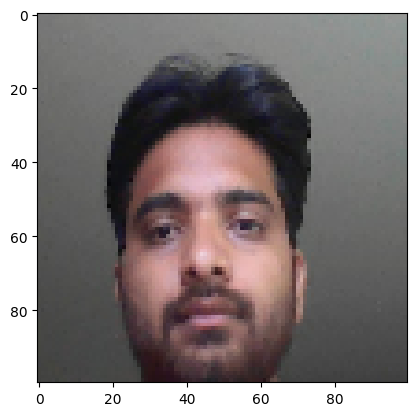

In [37]:
# anchor image or input image
plt.imshow(res[0])

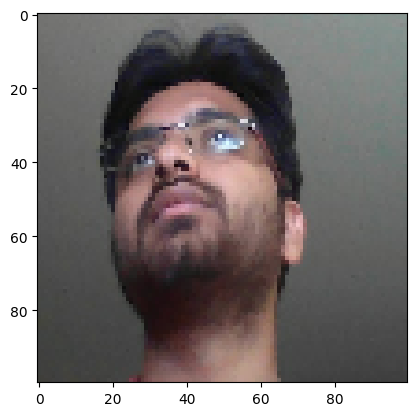

In [38]:
# positive sample so label should be 1
plt.imshow(res[1])

In [39]:
# positive label
res[2]

1.0

In [40]:
# build dataloader pipeline
data = data.map(preprocess_twin)
# cache the images
data = data.cache()
# shuffle the data before spliting into train and test
data = data.shuffle(buffer_size=1024)

In [41]:
# (anchor, positive or negative, label) in a shuffled order
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [42]:
samples = data.as_numpy_iterator()

In [43]:
len(samples.next())

3

In [44]:
samp = samples.next()

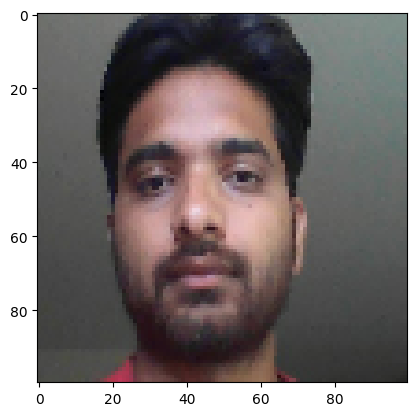

In [45]:
# anchor image
plt.imshow(samp[0])

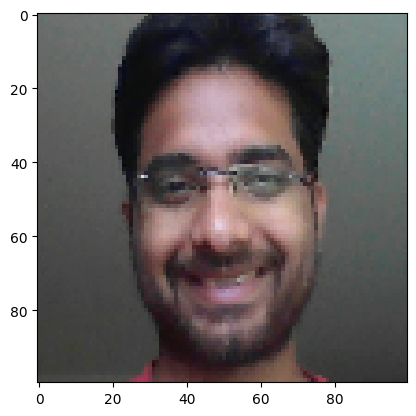

In [46]:
# we get negative image so label should be 1
plt.imshow(samp[1])

In [47]:
# since it's a negative image we should get label as 0
samp[2]

1.0

In [48]:
# check another image
samp = samples.next()

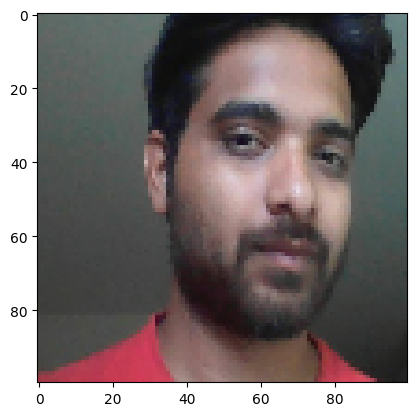

In [49]:
# another anchor image
plt.imshow(samp[0])

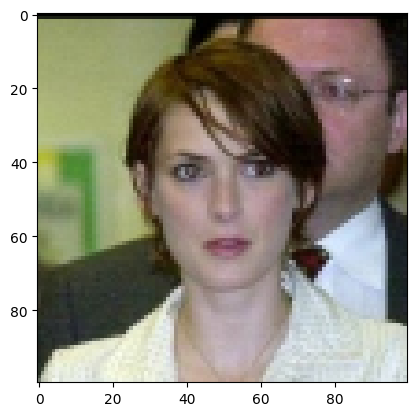

In [50]:
# negative image so label should be 0
plt.imshow(samp[1])

In [51]:
# label of positive image
samp[2]

0.0

In [52]:
round(0.7 * len(data))

1050

In [53]:
# shape of data = (anchor image, positive or negative image, label))
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [54]:
# training partition

# 70% of data for training
train_data = data.take(round(0.7 * len(data)))
# batch size = 16
train_data = train_data.batch(16)

'''
prefetch : When the GPU is working on forward / backward propagation on the current batch, we want the CPU to process the next batch of data so that it is immediately ready. 
As the most expensive part of the computer, we want the GPU to be fully used all the time during training. 
We call this consumer / producer overlap, where the consumer is the GPU and the producer is the CPU.

https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options

https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do
'''
train_data = train_data.prefetch(8)

In [55]:
# shape of train data
# ((no. of images in batch, anchor image, positive or negative image, label), (), ())
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [56]:
train_samples = train_data.as_numpy_iterator()

In [57]:
train_sample = train_samples.next()

In [58]:
# bacth size is 16. so each train_sample will have 16 images instead of single image
len(train_sample[0])

16

In [59]:
# Testing partition

# skipping 70% of data for test data
test_data = data.skip(round(0.7 * len(data)))
# grabbing 30% of data for test data
test_data = test_data.take(round(0.3 * len(data)))
# batch size = 16
test_data = test_data.batch(16)
# prefetch
test_data = test_data.prefetch(8)

# 4. Model Engineering

-  build an embedding layer

-  create an L1 distance layer

-  compile the siamese network


#### 4.1 Build Embedding Layer

In [60]:
def make_embedding():
    """ base on research paper convolutional architecture

    Returns:
        Model: _description_
    """
    # first block
    # our input images are of shape 100*100*3. Slighting different from research paper
    input_img = Input(shape=(100, 100, 3), name = "input_image")
    # 64 filters of convolutional layer of size 10*10
    conv_layer1 = Conv2D(64, (10, 10), activation = "relu" )(input_img)
    # 64 filters of max pooling of size 2*2
    max_pool1 = MaxPooling2D(64, (2,2), padding = "same")(conv_layer1)
    
    # second block
    # 128 filters of convolutional layer of size 7*7
    conv_layer2 = Conv2D(128, (7, 7), activation = "relu" )(max_pool1)
    # 64 filters of max pooling of size 2*2
    max_pool2 = MaxPooling2D(64, (2,2), padding = "same")(conv_layer2)
    
    # third block
    # 128 filters of convolutional layer of size 4*4
    conv_layer3 = Conv2D(128, (4, 4), activation = "relu" )(max_pool2)
    # 64 filters of max pooling of size 2*2
    max_pool3 = MaxPooling2D(64, (2,2), padding = "same")(conv_layer3)
    
    # final embedding block
    # 256 filters of convolutional layer of size 4*4
    conv_layer4 = Conv2D(256, (4, 4), activation = "relu" )(max_pool3)
    # flatten the convolutional layer to single dimension
    flatter_layer1 = Flatten()(conv_layer4)
    # dense layer of 4096 neurons
    dense_layer1 = Dense(4096, activation = "sigmoid")(flatter_layer1)
    
    
    return Model(inputs = [input_img], outputs=[dense_layer1], name="embedding")

In [61]:
embedding_model = make_embedding()

In [62]:
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

#### 4.2 Build Distance Layer

In [63]:
class L1Dist(Layer):
    """ custom L1 layer to calculate L1 distance between two images

    Args:
        Layer : base class
    """
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embeddings, validation_embeddings):
        """return the L1 distance between two images i.e performing similarity calculation

        Args:
            input_embeddings : anchor image
            validation_embeddings : positive or negative image

        Returns:
            _type_: _description_
        """
        # calculate the distance between anchor or input image and positive or negative image
        distance = tf.math.abs(input_embeddings - validation_embeddings)
        return distance

In [64]:
l1_dist_obj = L1Dist()

#### 4.3 Make Siamese model

In [65]:

def make_siamese_model():
    """generate siamese model
    """
    
    # anchor image input in the network
    input_img = Input(shape=(100, 100, 3), name = "input_image")
    
    # validation image in the network
    validation_img = Input(shape=(100, 100, 3), name = "validation_image")
    
    # Combine siamese distance components
    siamese_layer_obj = L1Dist()
    # set the name which will be used in model.summary()
    siamese_layer_obj._name = "distance"
    # perform embedding on anchor image and validation image
    distances = siamese_layer_obj(embedding_model(input_img), embedding_model(validation_img))
    
    # classification layer
    clf = Dense(1, activation = "sigmoid")(distances)
    
    # we send both anchor and validation image as input to the network 
    return Model(inputs = [input_img, validation_img], outputs=[clf], name="Siamese_model")
    
    

#### Perform Check:

In [66]:
# checking the embedding applied to anchor image

# input_img = Input(shape=(100, 100, 3), name = "input_image")
# inp_embedding = embedding_model(input_img)
# inp_embedding

In [67]:
# checking the embedding applied to validation image
# validation_img = Input(shape=(100, 100, 3), name = "validation_image")
# val_embedding = embedding_model(validation_img)
# val_embedding

In [68]:
# siamese_layer_obj = L1Dist()

In [69]:
# distances = siamese_layer_obj(inp_embedding, val_embedding)

In [70]:
# distances

In [71]:
# clf = Dense(1, activation="sigmoid")(distances)

In [72]:
# output of siamese model having shape 1
# clf

In [73]:
# siamese_model = Model(inputs = [input_img, validation_img], outputs=[clf], name="Siamese_model")

In [74]:
# siamese_model.summary()

#### Summary of the siamese model

In [75]:
# calling the siamese model

siamese_model = make_siamese_model()

In [76]:
# this is the summary of siamese model
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]      

### Training the model

#### Setup the optimizer and loss function

In [77]:
# loss function
binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy()

In [78]:
# optimizer
adam_optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### Establish checkpoints

In [79]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# save both model and optimizer state in checkpoint
checkpoint = tf.train.Checkpoint(optimizer = adam_optimizer, siamese_model = siamese_model)

#### Build train step function

In [80]:
@tf.function # it compiles an entire neural network into a graph and allows us to train it in an efficient way
def train_step(batch):
    # GradientTape perfroms automatic differentiation and records all the operations
    with tf.GradientTape() as tape:
        # get anchor image and validation image i.e. positive/negative image
        x = batch[:2]
        # get the label of the image
        y = batch[2]
        
        # Forward pass
        y_pred = siamese_model(x, training=True)
        # calculate the loss
        binary_cross_loss_val = binary_crossentropy_loss(y, y_pred)
    
    print(f"loss = {binary_cross_loss_val}")
    
    # calculate the gradients from the recorded operations i.r. tape for all of the trainable variables
    grad = tape.gradient(binary_cross_loss_val, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model
    adam_optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return binary_cross_loss_val
        


#### Build Training Loop

In [81]:
def train(train_data, EPOCHS):
    # loop through the epochs
    for epoch in range(1, EPOCHS + 1):
        print(f"Epoch {epoch}/{EPOCHS}")
        prog_bar = tf.keras.utils.Progbar(len(train_data))
        
        # creating a metric object to calculate recall and precision
        recall = Recall()
        precision = Precision()
        
        # loop through each batch
        for idx, batch in enumerate(train_data):
            # run train step here
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            recall.update_state(batch[2], y_pred)
            precision.update_state(batch[2], y_pred)
            prog_bar.update(idx + 1)
            
        print(f"loss = {loss.numpy()}")
        print(f"recall = {recall.result().numpy()}")
        print(f"precision = {precision.result().numpy()}")
            
        # save checkpoint after each epoch
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

#### Train the model

In [82]:
EPOCHS = 20

In [83]:
train(train_data, EPOCHS)

Epoch 1/20
loss = Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
loss = Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
66/66 [==============================] - 92s 1s/step
loss = 0.07035823166370392
recall = 0.6187845468521118
precision = 0.9795918464660645
Epoch 2/20
66/66 [==============================] - 76s 1s/step
loss = 0.0030384412966668606
recall = 0.9437386393547058
precision = 0.9961685538291931
Epoch 3/20
66/66 [==============================] - 77s 1s/step
loss = 0.030849773436784744
recall = 0.9635701179504395
precision = 0.9962335228919983
Epoch 4/20
66/66 [==============================] - 78s 1s/step
loss = 0.16570357978343964
recall = 0.9487179517745972
precision = 0.9942418336868286
Epoch 5/20
66/66 [==============================] - 79s 1s/step
loss = 0.009100263006985188
recall = 0.9797794222831726
precision = 0.9962616562843323
Epoch 6/20
66/66 [==============================] - 79s 1s/step
loss = 0.01295

# Evalute Model

### Make Predictions

In [81]:
# get a batch of test data
test_input, test_vl, y_true = test_data.as_numpy_iterator().next()

In [82]:
test_input

array([[[[0.42843136, 0.44607842, 0.44117647],
         [0.42352942, 0.43137255, 0.42745098],
         [0.4254902 , 0.43333334, 0.42941177],
         ...,
         [0.4627451 , 0.54901963, 0.5411765 ],
         [0.48333332, 0.56960785, 0.5617647 ],
         [0.47745097, 0.5617647 , 0.5509804 ]],

        [[0.42058823, 0.42647058, 0.42352942],
         [0.4127451 , 0.422549  , 0.41862744],
         [0.41862744, 0.42843136, 0.4245098 ],
         ...,
         [0.4480392 , 0.53431374, 0.5264706 ],
         [0.4715686 , 0.5686275 , 0.5598039 ],
         [0.4627451 , 0.5617647 , 0.55196077]],

        [[0.41666666, 0.4245098 , 0.42058823],
         [0.4107843 , 0.42647058, 0.422549  ],
         [0.4       , 0.43235293, 0.42156863],
         ...,
         [0.45882353, 0.5392157 , 0.53431374],
         [0.4509804 , 0.54509807, 0.54509807],
         [0.45294118, 0.54901963, 0.5480392 ]],

        ...,

        [[0.28627452, 0.28921568, 0.27254903],
         [0.2784314 , 0.28137255, 0.2647059 ]

In [83]:
test_vl

array([[[[8.98039222e-01, 9.17647064e-01, 9.29411769e-01],
         [9.05882359e-01, 9.25490201e-01, 9.37254906e-01],
         [9.02941167e-01, 9.22549009e-01, 9.34313715e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[9.00980413e-01, 9.20588255e-01, 9.32352960e-01],
         [9.06127453e-01, 9.25735295e-01, 9.37500000e-01],
         [9.06862736e-01, 9.26470578e-01, 9.38235283e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[9.00980413e-01, 9.20588255e-01, 9.32352960e-01],
         [9.09803927e-01, 9.29411769e-01, 9.41176474e-01],
         [9.09803927e-01, 9.29411769e-01, 9.41176474e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [

In [84]:
y_true

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [85]:
test_var = test_data.as_numpy_iterator().next()

In [86]:
len(test_var[0])

16

In [87]:
len(test_var[1])

16

In [88]:
len(test_var[2])

16

In [89]:
# Make predictions

y_pred = siamese_model.predict([test_input, test_vl])
y_pred

array([[5.1118286e-07],
       [1.0000000e+00],
       [9.9914324e-01],
       [1.0367334e-09],
       [1.0000000e+00],
       [1.9875988e-04],
       [6.3269850e-05],
       [1.0000000e+00],
       [1.0115578e-08],
       [1.9707771e-09],
       [9.9999928e-01],
       [8.6272344e-08],
       [1.7637977e-10],
       [6.3768280e-06],
       [1.8497667e-10],
       [1.5152117e-09]], dtype=float32)

In [90]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_pred]

[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

### Calculate Metrics - Recall, Precision

In [91]:
# recall metric object
recall = Recall()

# calculate recall
recall.update_state(y_true, y_pred)

# return the recall value
recall.result().numpy()

1.0

In [92]:
# precision metric object
precision = Precision()

# calculate precision
precision.update_state(y_true, y_pred)

# return the precision value
precision.result().numpy()

1.0

### Visualize Results

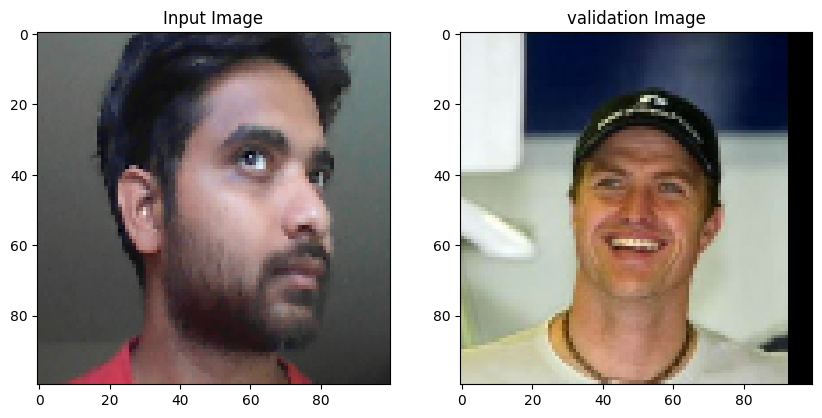

In [93]:
# set the plot size
plt.figure(figsize=(10, 8))

# set 1st subplot - row, column, index
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(test_input[0])

# set 2nd subplot - row, column, index
plt.subplot(1, 2, 2)
plt.title("validation Image")
plt.imshow(test_vl[0])
plt.show()

### Save Model

In [109]:
# save the weights of the model
siamese_model.save("siamese_model")

INFO:tensorflow:Assets written to: siamese_model\assets


In [84]:
# Reloding the model

reconstructed_model = tf.keras.models.load_model("siamese_model.h5",
                                  custom_objects = {"L1Dist": L1Dist})

IndexError: list index out of range

# Real Time Testing

#### Verification Function

In [145]:
# os.path.join("application_data", "verification_images")

'application_data\\verification_images'

In [146]:
# list all the images in the folder
# os.listdir(os.path.join("application_data", "verification_images"))

['1bd3fe45-321a-11ed-a7cb-509a4cb51153.jpg',
 '1c22e067-321a-11ed-a091-509a4cb51153.jpg',
 '1c49d137-321a-11ed-97fb-509a4cb51153.jpg',
 '1c93ed2d-321a-11ed-b195-509a4cb51153.jpg',
 '1d1ba3dc-321a-11ed-98d7-509a4cb51153.jpg',
 '1d243862-321a-11ed-9127-509a4cb51153.jpg',
 '1d562ab4-321a-11ed-aae2-509a4cb51153.jpg',
 '2b068937-321a-11ed-9c26-509a4cb51153.jpg',
 '2b416a81-321a-11ed-985d-509a4cb51153.jpg',
 '2b655b34-321a-11ed-8e83-509a4cb51153.jpg',
 '2baab1d2-321a-11ed-a273-509a4cb51153.jpg',
 '2bd8bdcb-321a-11ed-863a-509a4cb51153.jpg',
 '3b7dd270-321a-11ed-8d90-509a4cb51153.jpg',
 '4a05567a-321a-11ed-9825-509a4cb51153.jpg',
 '4a09dd78-321a-11ed-ad88-509a4cb51153.jpg',
 '4a64c368-321a-11ed-8088-509a4cb51153.jpg',
 '4a6a630f-321a-11ed-966b-509a4cb51153.jpg',
 '4a8a85d8-321a-11ed-8f68-509a4cb51153.jpg',
 '4aae1a10-321a-11ed-b1ee-509a4cb51153.jpg',
 '4af7f03e-321a-11ed-890e-509a4cb51153.jpg',
 '4b313106-321a-11ed-be7b-509a4cb51153.jpg',
 '4b481821-321a-11ed-aca9-509a4cb51153.jpg',
 '4b5132d4

In [2]:
# detection threshold: Metric above which a prediction is considered as positive
# verifiacation threshold: Propostion of positive predictions / total positive sample
def verify(model, detection_threshold, verification_threshold):
    results_lst = []
    
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results_lst.append(result)
    
    # detection threshold
    detection = np.sum(np.array(results_lst) > detection_threshold)
    # verification threshold
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold
    
    return results_lst, verified

#### OpecnCV Real Time Verification

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # resize the frame to 250 x 250
    frame = frame[120:120 + 250, 200:200 + 250,:]
    if ret:
        cv2.imshow("Verification", frame)
        
        # Verification trigger
        if cv2.waitKey(1) & 0xFF == ord("v"):
            # save input image to application_data/input_image folder
            cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
            
            # Perform verification
            results, verified = verify(siamese_model, 0.5, 0.5)
            print(f"Verified status: {verified}")
            
        
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

# References

https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa

https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options

https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do